In [1]:
# Enable further imports

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import matplotlib.pyplot as plt
import torch

from torch.nn import ModuleList, CrossEntropyLoss, Sequential
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

from tqdm.notebook import tqdm

from data import BinaryColoredMNIST, BiasedCifar10, BiasedBinaryMNIST, BiasedDataset

from models import MLPEncoder, ConvEncoder, ConvEncoderCIFAR, Classifier, Adversary

from train import Trainer

from predict import Predictor

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cpu


### Data Modification

In [4]:
def generate_p_y_a(bias, C, K):
    if bias >= 1.0:
        raise ValueError("bias has to be in the interval [0, 1)")
        
    p_y_a = torch.zeros(C, K)

    dominant_classes = torch.randperm(C)[:K]

    for j in range(K):
        
        uniform = torch.full((C,), 1.0 / C, device=device)
        
        one_hot = torch.zeros(C, device=device)
        one_hot[dominant_classes[j].item()] = 1.0
        
        p_y_a[:, j] = (1 - bias) * uniform + bias * one_hot

    return p_y_a

def entropy(p):
    mask = p > 0
    return -(p[mask] * torch.log2(p[mask])).sum()

def nmi(p_y_a, p_a):
    K, C = p_y_a.shape
    
    p_joint = p_a[:, None] * p_y_a
    p_y = p_joint.sum(dim=0)

    mi_matrix = torch.zeros_like(p_joint)
    ratio = p_y_a / p_y
    mi_matrix[p_joint > 0] = p_joint[p_joint > 0] * torch.log2(ratio[p_joint > 0])
    mi = mi_matrix.sum()

    H_y = entropy(p_y)
    H_a = entropy(p_a)

    nmi = mi / torch.sqrt(H_y * H_a) if H_y > 0 and H_a > 0 else torch.tensor(0.0)
    return nmi

In [5]:
C = 5
K = 5

p_y_a = generate_p_y_a(0.7, C, K)
p_y_a

tensor([[0.7600, 0.0600, 0.0600, 0.0600, 0.0600],
        [0.0600, 0.0600, 0.0600, 0.7600, 0.0600],
        [0.0600, 0.7600, 0.0600, 0.0600, 0.0600],
        [0.0600, 0.0600, 0.0600, 0.0600, 0.7600],
        [0.0600, 0.0600, 0.7600, 0.0600, 0.0600]])

In [6]:
data_dir = os.path.join(project_root, "data/cifar_data")
C = 10
K = 10

p_y_a = generate_p_y_a(0, C, K)
# p_y_a = torch.tensor(
#     [[0.2, 0.6],
#     [0.8, 0.4]]
# )

train_set = BiasedCifar10(data_dir, p_y_a, device=device)
test_set = BiasedCifar10(data_dir, generate_p_y_a(0.0, C, K), train=False, device=device)

# train_set = BinaryColoredMNIST(data_dir, 0.9, 0.1, device=device)
# test_set = BinaryColoredMNIST(data_dir, 0.5, 0.5, train=False, device=device)

# train_set = BiasedBinaryMNIST(data_dir, p_y_a, device=device)
# test_set = BiasedBinaryMNIST(data_dir, generate_p_y_a(0.0, C, K), train=False, device=device)

# print(f"NormalizedMutualInformation(Y; A) = {nmi(train_set.p_y_a, train_set.p_a):.4f}")

self.p_a = tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
self.p_a = tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])


In [7]:
# train_set, val_set = random_split(train_set, [0.8, 0.2])

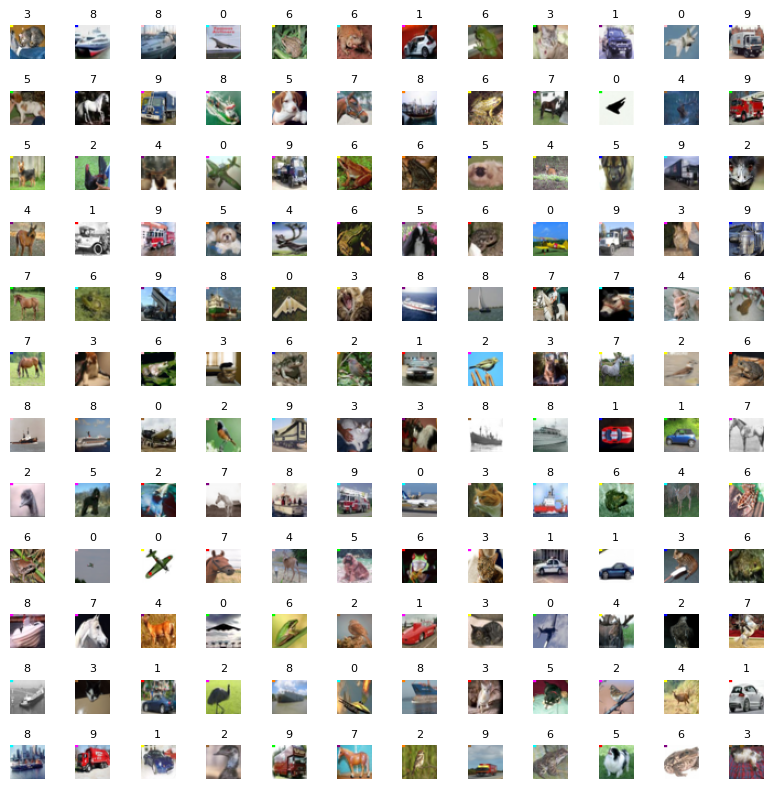

In [8]:
data = train_set[:144]

plt.figure(figsize=(8, 8))

for i, (img, a, label) in enumerate(zip(*data)):
    plt.subplot(12, 12, i + 1)
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.title(str(label.item()), fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [9]:
# Setup for DP
latent_dim = 24

batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
val_loader = None

encoder = ConvEncoderCIFAR(latent_dim)
classifier = Classifier(latent_dim, C=C)
adversary = Adversary(latent_dim, K=K)

trainer = Trainer(train_loader, val_loader, encoder, classifier, adversary, C, K, device)

In [15]:
gamma = 0
learning_rate = 1e-3
epochs = 20

criterion_class = CrossEntropyLoss()
optimizer_enc_class = Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate, weight_decay=5e-4)
optimizer_adv = Adam(adversary.parameters(), lr=learning_rate, weight_decay=5e-4)

losses_enc, losses_adv = trainer.train(criterion_class, optimizer_enc_class, optimizer_adv, gamma, epochs, True)

  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 1 (encoder+classifier loss: 1.8273, adversary loss: 7.9970)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 2 (encoder+classifier loss: 1.4261, adversary loss: 7.9912)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 3 (encoder+classifier loss: 1.1835, adversary loss: 7.9790)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 4 (encoder+classifier loss: 0.9536, adversary loss: 7.9539)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 5 (encoder+classifier loss: 0.7445, adversary loss: 7.9334)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 6 (encoder+classifier loss: 0.4908, adversary loss: 7.8944)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 7 (encoder+classifier loss: 0.3245, adversary loss: 7.8729)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 8 (encoder+classifier loss: 0.2432, adversary loss: 7.8602)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 9 (encoder+classifier loss: 0.1801, adversary loss: 7.8306)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 10 (encoder+classifier loss: 0.0945, adversary loss: 7.8115)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 11 (encoder+classifier loss: 0.0575, adversary loss: 7.8107)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 12 (encoder+classifier loss: 0.0523, adversary loss: 7.8011)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 13 (encoder+classifier loss: 0.0303, adversary loss: 7.7724)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 14 (encoder+classifier loss: 0.0385, adversary loss: 7.7827)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 15 (encoder+classifier loss: 0.1255, adversary loss: 7.7477)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 16 (encoder+classifier loss: 0.1127, adversary loss: 7.7704)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 17 (encoder+classifier loss: 0.1168, adversary loss: 7.7983)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 18 (encoder+classifier loss: 0.1488, adversary loss: 7.7819)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 19 (encoder+classifier loss: 0.1322, adversary loss: 7.7569)


  0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 20 (encoder+classifier loss: 0.1163, adversary loss: 7.7089)


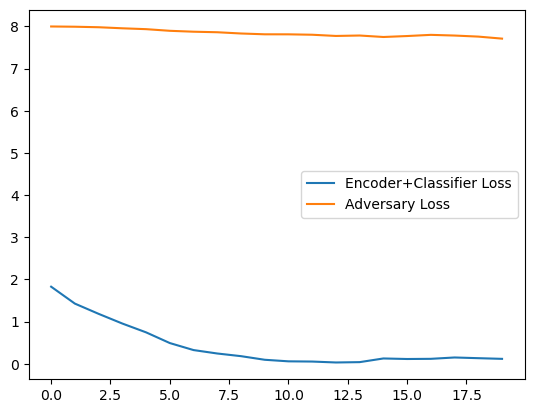

In [16]:
plt.plot(losses_enc, label="Encoder+Classifier Loss")
plt.plot(losses_adv, label="Adversary Loss")

plt.legend()
plt.show()

In [17]:
predict_adversary = Predictor(model=adversary, N=K)
predict_classifier = Predictor(model=classifier, N=C)

x, a_true, y_true = test_set[:]

z = encoder(x)

a_pred = predict_adversary.predict_class(z, y_true)
y_pred = predict_classifier.predict_class(z)

# test_loader = tqdm(
#     DataLoader(test_set, batch_size=batch_size, shuffle=True),
#     unit="batch",
#     leave=False
# )

# y_pred = []
# y_true = []
# a_pred = []
# a_true = []

# for (x, a, y) in test_loader:
#     x = x.to(device)
#     a = a.to(device)
#     y = y.to(device)

#     z = encoder(x)
    
#     y_preds = classifier(z).argmax(dim=1)
#     a_preds = trainer.pred_adversary(z, y).argmax(dim=1)
    
#     a_pred.append(a_preds.cpu())
#     y_pred.append(y_preds.cpu())
    
#     a_true.append(a.cpu())
#     y_true.append(y.cpu())

# a_pred = torch.cat(a_pred, dim=0).numpy()
# a_true = torch.cat(a_true, dim=0).numpy()

# y_pred = torch.cat(y_pred, dim=0).numpy()
# y_true = torch.cat(y_true, dim=0).numpy()

In [18]:
print("Classifier:")
predict_classifier.print_classification_report(y_true, y_pred)

print()
print()

print("Adversary:")
predict_adversary.print_classification_report(a_true, a_pred)

Classifier:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1000
           1       1.00      0.98      0.99      1000
           2       0.97      0.99      0.98      1000
           3       0.99      0.96      0.98      1000
           4       0.99      0.98      0.98      1000
           5       0.98      0.99      0.99      1000
           6       0.98      1.00      0.99      1000
           7       0.99      0.98      0.99      1000
           8       0.99      0.99      0.99      1000
           9       1.00      0.98      0.99      1000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



Adversary:
              precision    recall  f1-score   support

           0       0.09      0.10      0.09       985
           1       0.00      0.00      0.00       953
           2       0.00      0.00      0.00      1063

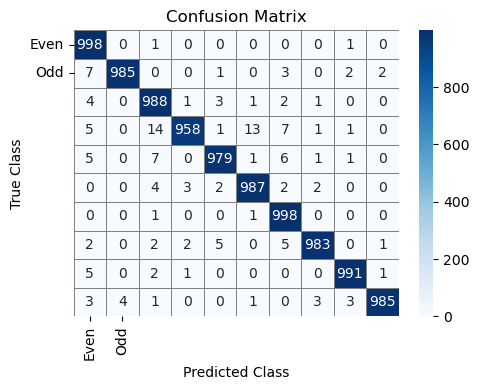

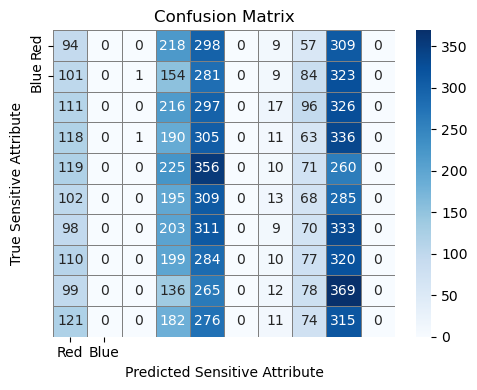

In [19]:
class_cm = predict_classifier.plot_confusion_matrix(y_true, y_pred, labels_names=['Even', 'Odd'], ylabel='True Class', xlabel='Predicted Class') 

adv_cm = predict_adversary.plot_confusion_matrix(a_true, a_pred, labels_names=['Red', 'Blue'], ylabel='True Sensitive Attribute', xlabel='Predicted Sensitive Attribute')